# <div style="text-align: center"> <font size=+5> <ins>ANALYSE DATA</ins> </font> </div>
___

# Loading variables

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams.update({'figure.dpi' : 300,
                     'mathtext.fontset' : 'stix', 
                     'font.family' : 'STIXGeneral'
                    })

In [2]:
data_issp = pd.read_pickle("Processed_Data/issp_questionnaires.pickle")
data_GDPgrowth = pd.read_pickle("Processed_Data/GDP_growth.pickle")
data_GDPpcap = pd.read_pickle("Processed_Data/GDP_pcap.pickle")

___
# Interesting variables

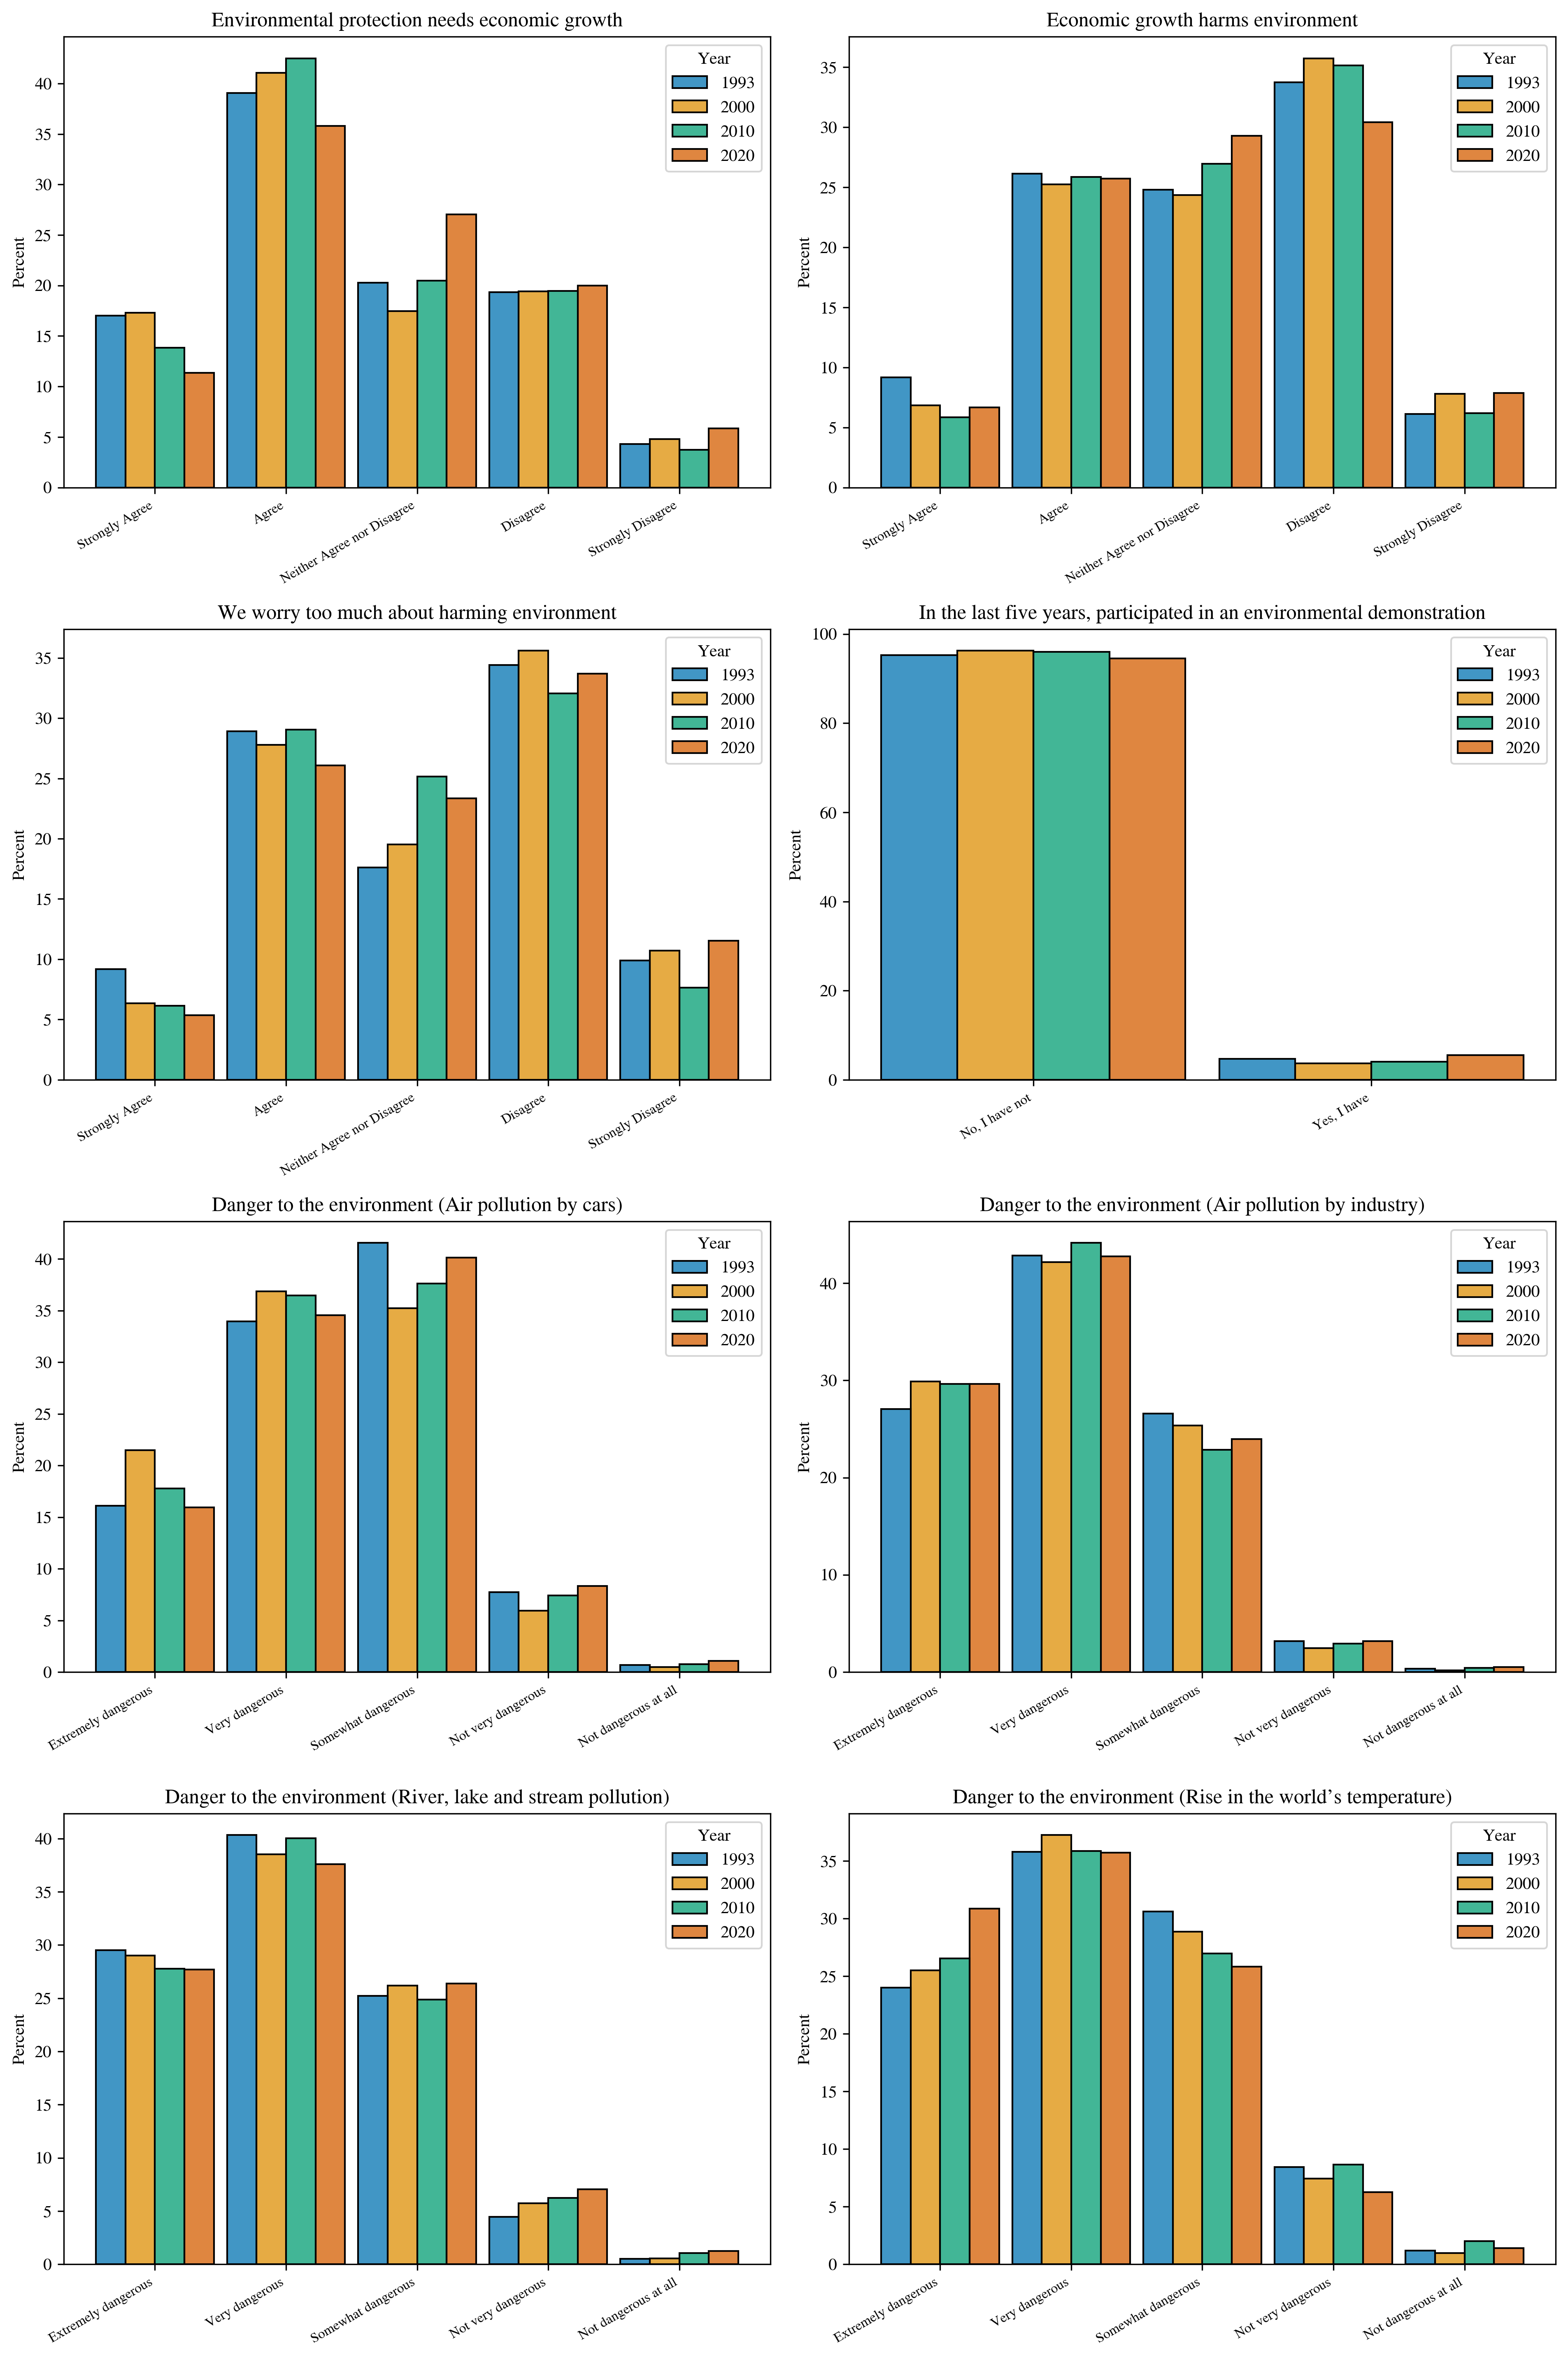

In [3]:
#plotting data
cols = [
    #economy vs environment (link to economic growth)
    'Environmental protection needs economic growth', 'Economic growth harms environment', 
    #environmental activism (link to policy implementation in different states)
    'We worry too much about harming environment', 'In the last five years, participated in an environmental demonstration',
    #perception of danger to environment (link to actual environmental data -> pollution levels / deaths because of pollution...)
    'Danger to the environment (Air pollution by cars)', 'Danger to the environment (Air pollution by industry)', 'Danger to the environment (River, lake and stream pollution)',
    #climate change (link to countries most affected by climate change -> extreme climate events...?
    'Danger to the environment (Rise in the world’s temperature)'
]
        

#cols = list(data_issp.columns.drop(["Country", "Respondent ID", "Weight", "year"])) #uncomment to plot all columns

fig, axs = plt.subplots(len(cols)//2, 2, figsize=(6.4*2,4.8*(len(cols)//2)))
for i,col in enumerate(cols):
    ax = axs[i//2, i%2]

    
    h = sns.histplot(data=data_issp.reset_index(), x=col, hue="Year", stat="percent", shrink=0.9, multiple="dodge", palette="colorblind", common_norm=False, ax=ax)

    ax.set_title(col)
    ax.set_xlabel("")
    for tick in ax.get_xticklabels():
        tick.set_fontsize(8)
        tick.set_horizontalalignment('right')
        tick.set_rotation(30)

plt.tight_layout()

___
# Economy and environment

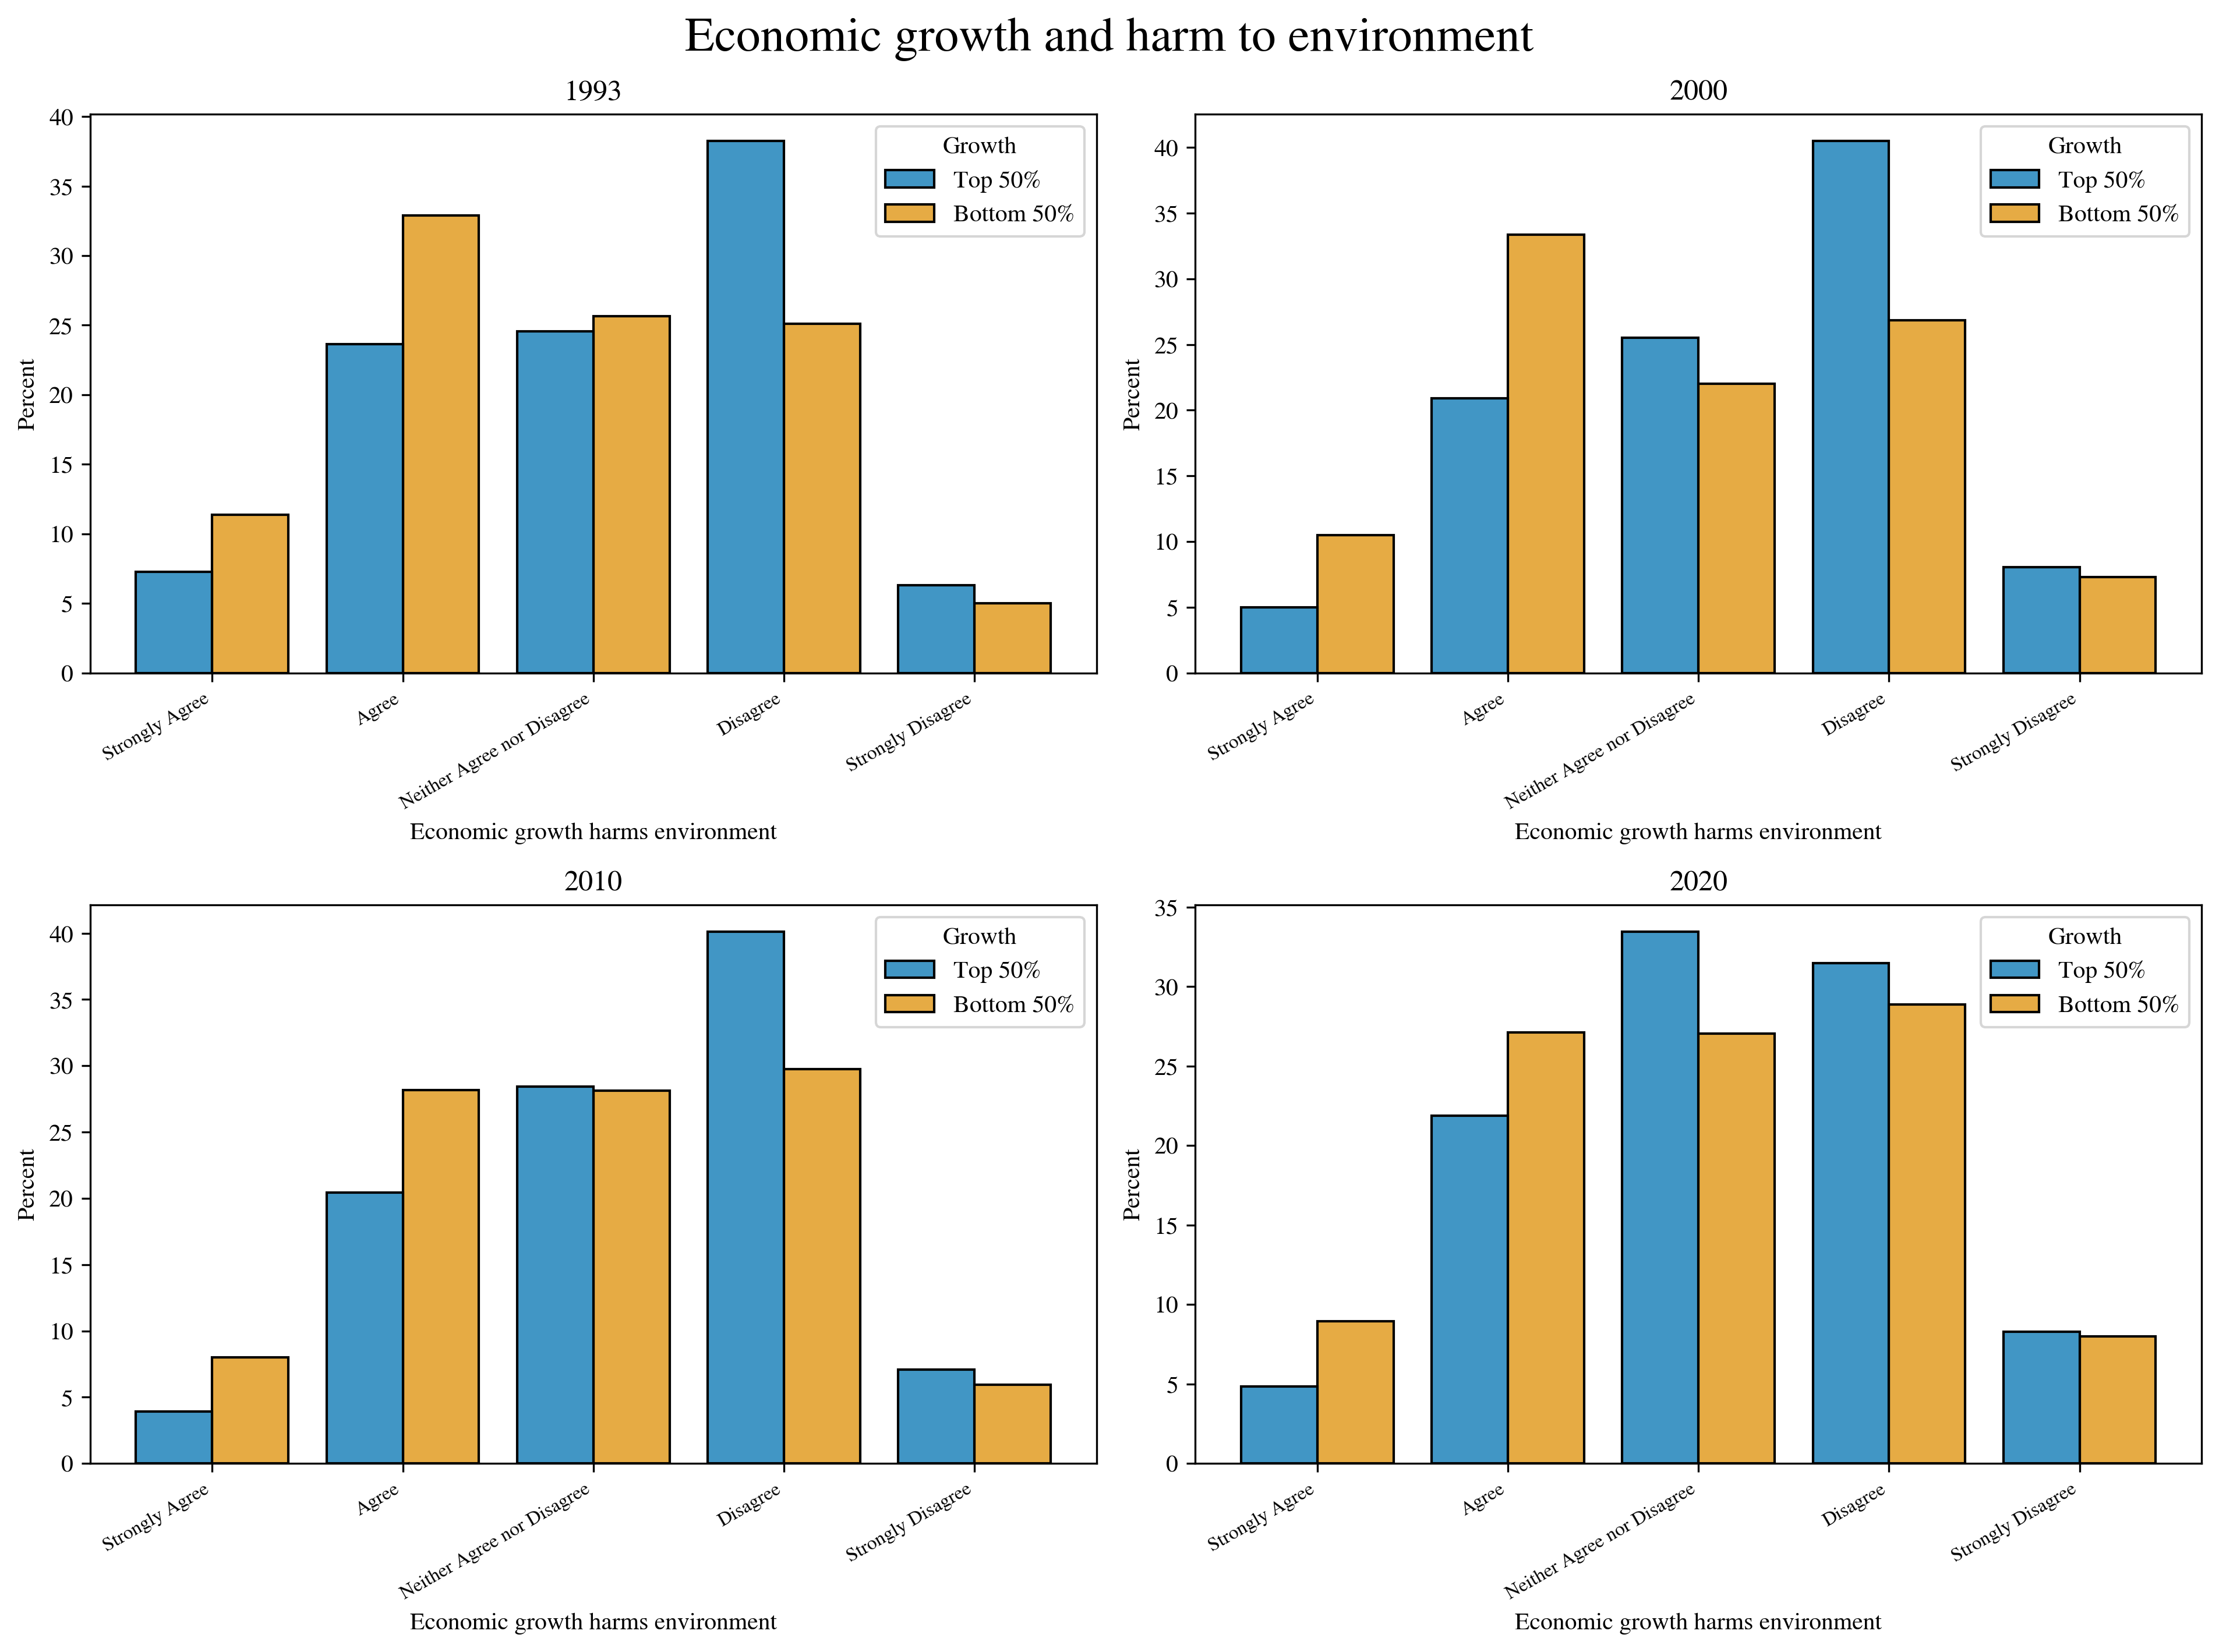

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(6.4*2,4.8*2))
fig.suptitle("Economic growth and harm to environment", fontsize=20)

for i, year in enumerate([1993,2000,2010,2020]):
    growing_countries = [c for c in data_GDPgrowth.index.drop("World") if data_GDPgrowth.loc[c, year] >= data_GDPgrowth.drop(index="World")[year].median()]

    ax = axs[i//2,i%2]
    data = data_issp.loc[(year, slice(None)),:].reset_index().copy()
    data["Growth"] = data["Country"].map(lambda x: "Top 50%" if x in growing_countries else "Bottom 50%")
    data = data.sort_values("Growth", axis=0, ascending=False)
    sns.histplot(data=data.query("Country != 'Taiwan'"), x="Economic growth harms environment", hue="Growth", weights="Weight", common_norm=False, multiple="dodge", stat="percent", shrink=0.8, palette="colorblind", ax=ax)
    ax.set_title(year)
    for tick in ax.get_xticklabels():
        tick.set_fontsize(8)
        tick.set_horizontalalignment('right')
        tick.set_rotation(30)
plt.tight_layout()

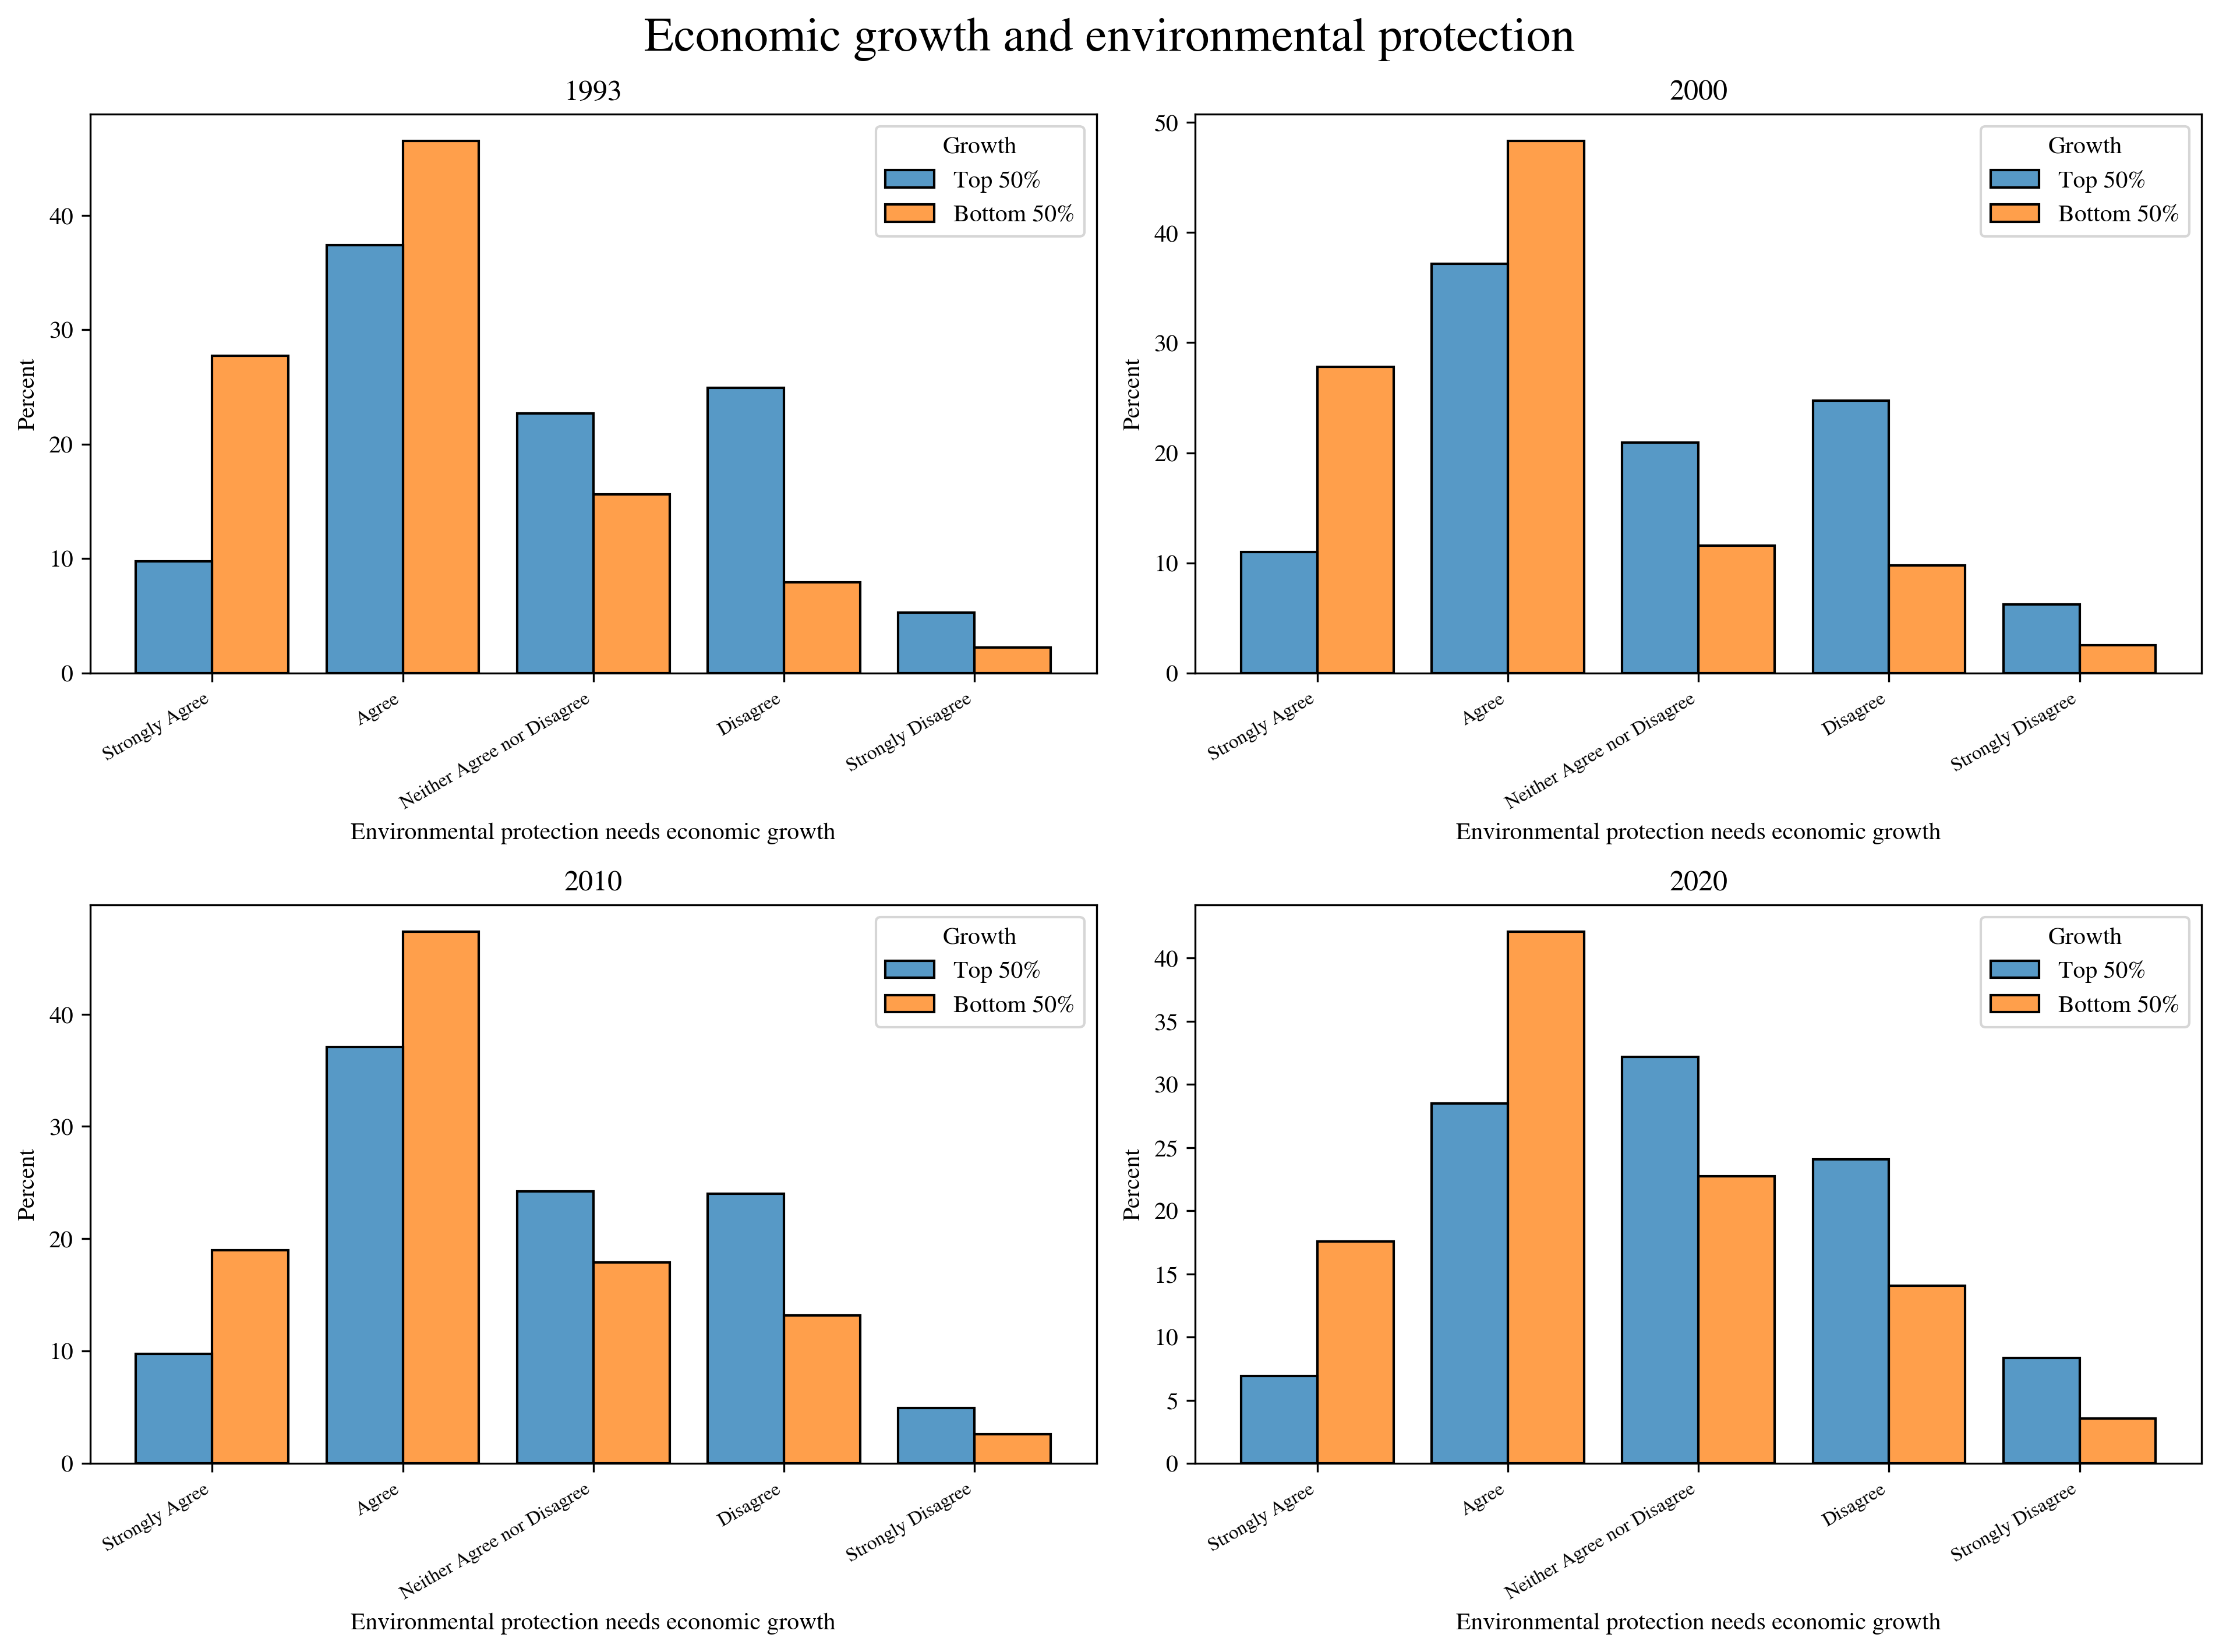

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(6.4*2,4.8*2))
fig.suptitle("Economic growth and environmental protection", fontsize=20)

for i, year in enumerate([1993,2000,2010,2020]):
    growing_countries = [c for c in data_GDPgrowth.index.drop("World") if data_GDPgrowth.loc[c, year] >= data_GDPgrowth.drop(index="World")[year].median()]

    ax = axs[i//2,i%2]
    data = data_issp.loc[(year, slice(None)),:].reset_index().copy()
    data["Growth"] = data["Country"].map(lambda x: "Top 50%" if x in growing_countries else "Bottom 50%")
    data = data.sort_values("Growth", axis=0, ascending=False)
    sns.histplot(data=data.query("Country != 'Taiwan'"), x="Environmental protection needs economic growth", hue="Growth", weights="Weight", common_norm=False, multiple="dodge", stat="percent", shrink=0.8, ax=ax)
    ax.set_title(year)
    for tick in ax.get_xticklabels():
        tick.set_fontsize(8)
        tick.set_horizontalalignment('right')
        tick.set_rotation(30)
plt.tight_layout()

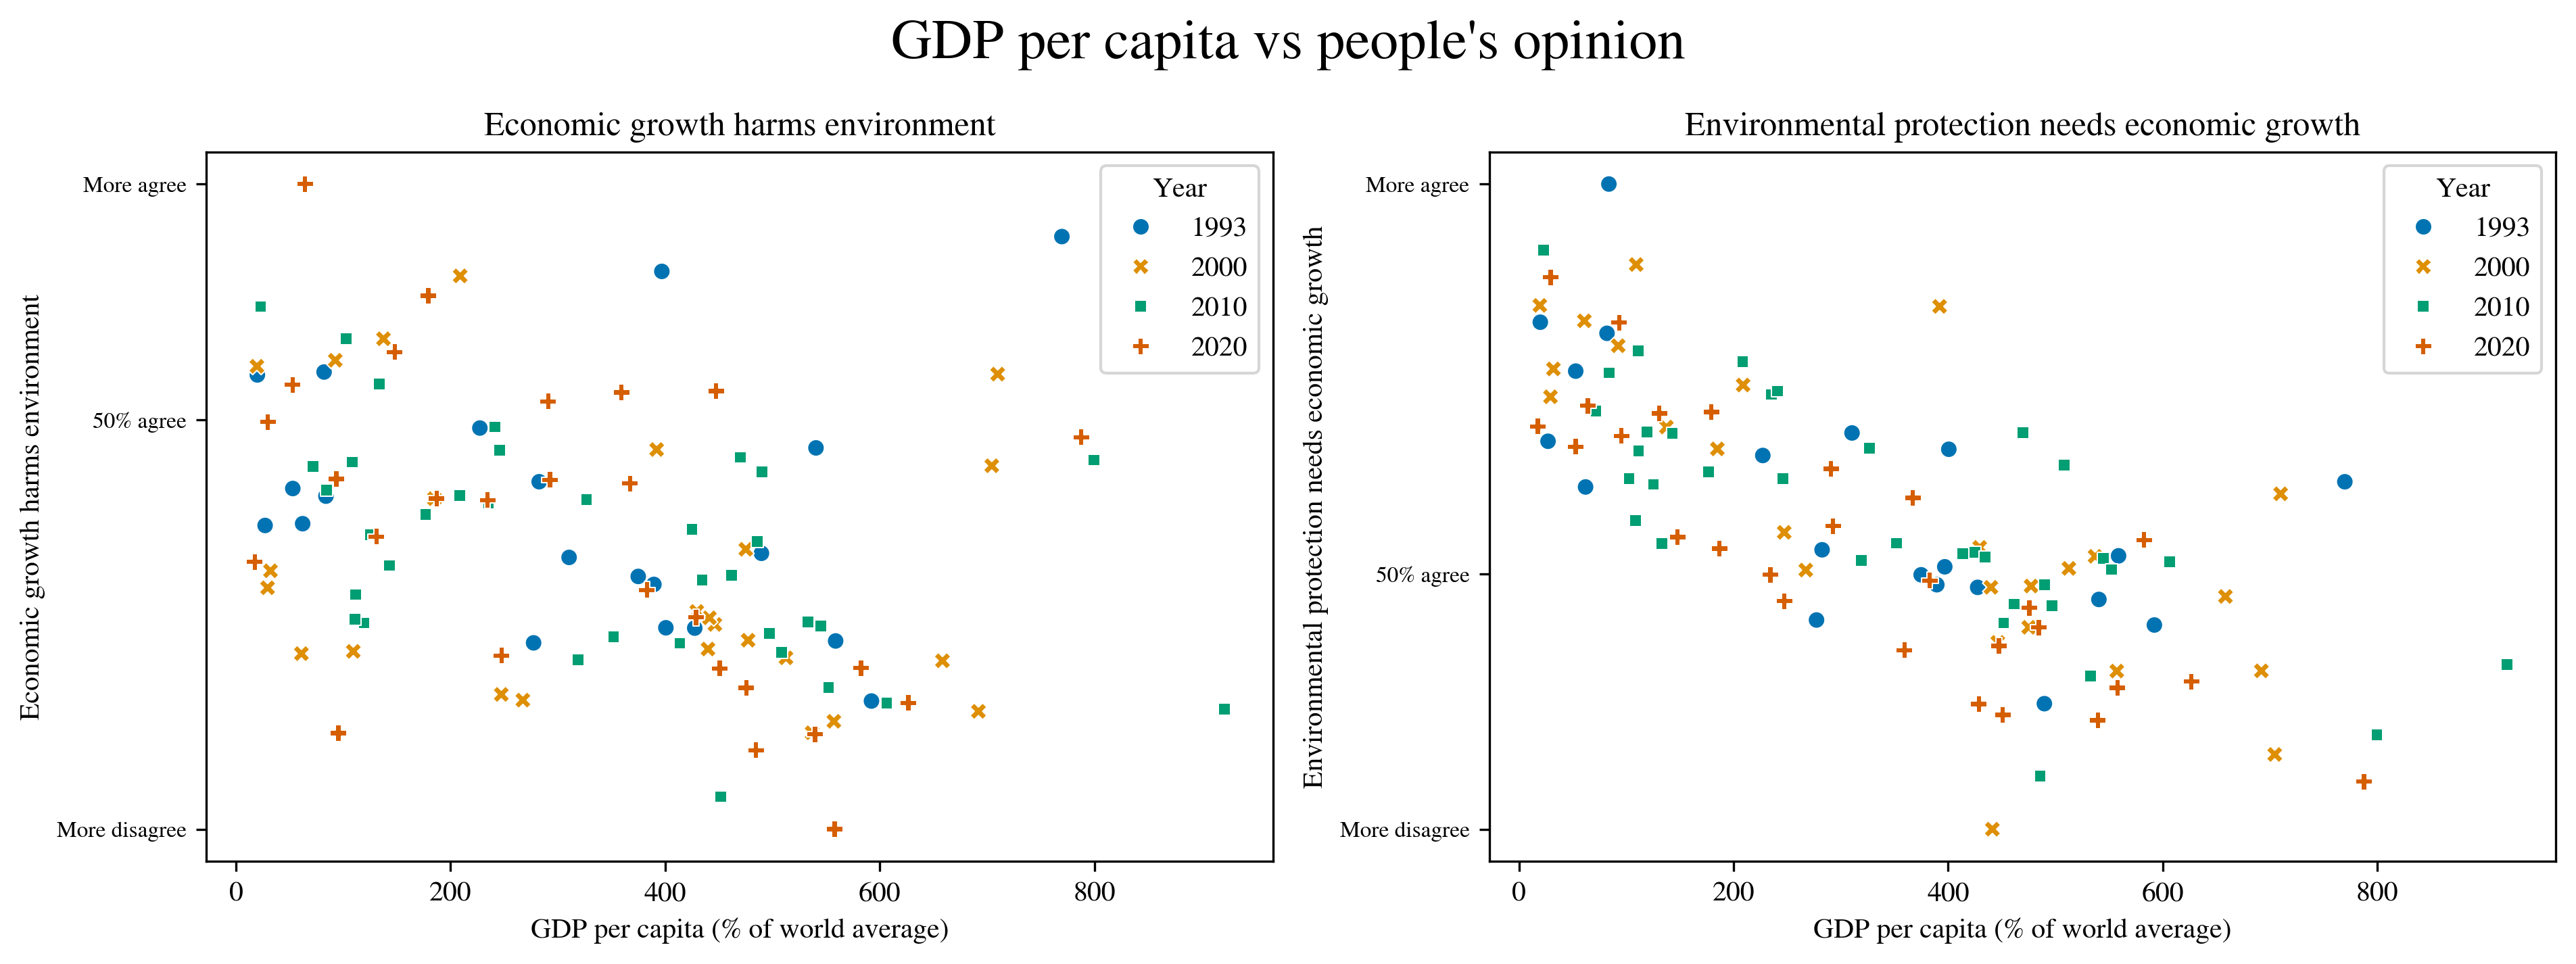

In [9]:
def conv_agree(label):
    convDict = {
        "Strongly Disagree" : 1,
        "Disagree" : 2,
        "Neither Agree nor Disagree" : 3,
        "Agree" : 4,
        "Strongly Agree" : 5
    }
    return convDict[label] if label in convDict else label


wm = lambda x: np.average(x.dropna(), weights=data.loc[x.index, "Weight"])

data = data_issp.query("Country != 'Taiwan'").loc[:,["Economic growth harms environment", "Environmental protection needs economic growth", "Weight"]].copy()
data = data.map(conv_agree).astype(float)
#data = data.groupby(["Year", "Country"]).mean() #unweighted mean
data = data[["Economic growth harms environment","Environmental protection needs economic growth"]].mul(data["Weight"], axis="index").groupby(["Year", "Country"]).sum().div(data["Weight"].groupby(["Year", "Country"]).sum(), axis="index")
#data["GDP per capita [US$]"] = data.index.map(lambda x: data_GDPpcap.loc[x[1], x[0]].copy())
data["GDP per capita (% of world average)"] = data.index.map(lambda x: 100*data_GDPpcap.loc[x[1], x[0]].copy() / data_GDPpcap.loc["World",x[0]].copy())


fig, axs = plt.subplots(1,2,figsize=(6.4*2,4.8), sharey=False)
fig.suptitle("GDP per capita vs people's opinion", fontsize=20)

for i, val in enumerate(["Economic growth harms environment", "Environmental protection needs economic growth"]):
    ax = axs[i]
    sns.scatterplot(data=data.reset_index(), x="GDP per capita (% of world average)", y=val, hue="Year", palette="colorblind", style="Year", ax=ax)
    ax.set_title(val)
    ax.set_yticks([data[val].min(), 3, data[val].max()])
    ax.set_yticklabels(["More disagree", "50% agree", "More agree"], fontsize=8)

plt.tight_layout()

___